In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import scipy.io

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

**Problem Statement**: You have just been hired as an AI expert by the French Football Corporation. They would like you to recommend positions where France's goal keeper should kick the ball so that the French team's players can then hit it with their head. 

<img src="images/field_kiank.png" style="width:600px;height:350px;">
<caption><center> <u> **Figure 1** </u>: **Football field**<br> The goal keeper kicks the ball in the air, the players of each team are fighting to hit the ball with their head </center></caption>


They give you the following 2D dataset from France's past 10 games.

### 载入数据集

In [2]:
def load_2D_dataset():
    data = scipy.io.loadmat('datasets/data.mat')
    train_X = data['X'].T
    train_Y = data['y'].T
    test_X = data['Xval'].T
    test_Y = data['yval'].T
    
    return train_X, train_Y, test_X, test_Y

In [3]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

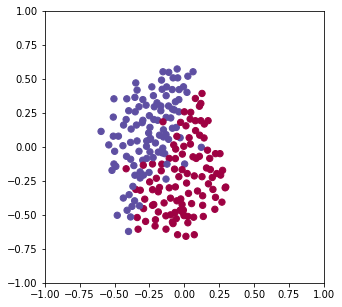

In [4]:
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.scatter(train_X[0, :], train_X[1, :], c=train_Y[0], s=40, cmap=plt.cm.Spectral);

Each dot corresponds to a position on the football field where a football player has hit the ball with his/her head after the French goal keeper has shot the ball from the left side of the football field.
- If the dot is blue, it means the French player managed to hit the ball with his/her head
- If the dot is red, it means the other team's player hit the ball with their head

**Your goal**: Use a deep learning model to find the positions on the field where the goalkeeper should kick the ball.

### Z-score标准化输入

In [5]:
train_X_mean = train_X.mean(axis=1).reshape(train_X.shape[0], 1)
train_X_std = train_X.std(axis=1).reshape(train_X.shape[0], 1)
train_X = (train_X - train_X_mean) / train_X_std
test_X = (test_X - train_X_mean) / train_X_std

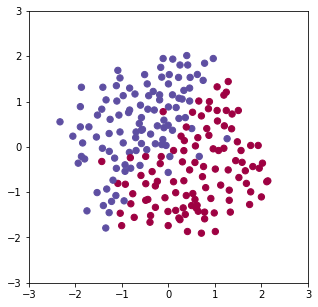

In [6]:
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.scatter(train_X[0, :], train_X[1, :], c=train_Y[0], s=40, cmap=plt.cm.Spectral);

### 深层神经网络（隐藏层ReLU 输出层sigmoid）

In [7]:
# sigmoid激活函数
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

In [8]:
# ReLU激活函数
def relu(Z):
    return np.maximum(0, Z)

In [9]:
# 初始化深层神经网络的参数 使用HE初始化
def initialize_parameters_he(layers_dims):
    parameters = {}
    
    # 深层神经网络的层数+1
    L = len(layers_dims)
    
    # 初始化 W b
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1]) * np.sqrt(2 / layers_dims[l - 1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
        
    return parameters

In [10]:
# 计算正向传播 ReLU->ReLU->...->Sigmoid
def forward_propagate(parameters, X):
    L = len(parameters) // 2
    
    caches = {}
    
    A = X
    caches['A0'] = A
    for l in range(1, L):
        Z = parameters['W' + str(l)] @ A + parameters['b' + str(l)]
        A = relu(Z)
        caches['A' + str(l)] = A
    
    Z = parameters['W' + str(L)] @ A + parameters['b' + str(L)]
    A = sigmoid(Z)
    caches['A' + str(L)] = A
    
    return A, caches

In [11]:
# 计算损失函数
def compute_cost(AL, Y):
    logprobs = Y * np.log(AL) + (1 - Y) * np.log(1 - AL)
    cost = -np.nanmean(logprobs)
    return cost

In [12]:
# 计算反向传播 Sigmoid->ReLU->...->ReLU
def backward_propagate(parameters, Y, caches):
    L = len(parameters) // 2
    
    grads = {}
    
    dZ = caches['A' + str(L)] - Y # cross-entropy cost对AL的偏导数 * sigmoid的导数
    grads['dW' + str(L)] = dZ @ caches['A' + str(L - 1)].T / dZ.shape[1]
    grads['db' + str(L)] = np.mean(dZ, axis=1, keepdims=True)
    
    for l in reversed(range(1, L)):
        dZ =  parameters['W' + str(l + 1)].T @ dZ * (caches['A' + str(l)] > 0) # ReLU的导数
        grads['dW' + str(l)] = dZ @ caches['A' + str(l - 1)].T / dZ.shape[1]
        grads['db' + str(l)] = np.mean(dZ, axis=1, keepdims=True)
    
    return grads

In [13]:
# 用梯度下降法更新参数
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2
    
    for l in range(1, L + 1):
        parameters['W' + str(l)] -= learning_rate * grads['dW' + str(l)]
        parameters['b' + str(l)] -= learning_rate * grads['db' + str(l)]
    
    return parameters

### 未正则化的模型

In [14]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.3, num_iterations = 30000, print_cost = False):
    # 初始化参数 W1 b1 ... WL bL
    parameters = initialize_parameters_he(layers_dims)
    
    # 损失函数记录
    costs = []
    
    # 梯度下降法循环迭代
    for i in range(num_iterations):
        AL, caches = forward_propagate(parameters, X)
        if print_cost:
            if i % 1000 == 0:
                cost = compute_cost(AL, Y)
                costs.append(cost)
                if i % 10000 == 0:
                    print ("Cost after iteration %i: %f" %(i, cost))
        grads = backward_propagate(parameters, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
    
    # 绘制损失函数
    if print_cost:
        plt.figure(figsize=(7.0, 4.0))
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
    return parameters

In [15]:
# 对样本进行预测
def predict(parameters, X):
    AL, caches = forward_propagate(parameters, X)
    AL = AL > 0.5
    return AL.astype(np.int)

In [16]:
# 计算准确率
def compute_accuracy(parameters, X, Y):
    P = predict(parameters, X)
    return float((Y @ P.T + (1 - Y) @ (1 - P.T)) / float(Y.size))

In [17]:
# 绘制决策边界图
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()

In [18]:
# 设定深层神经网络层数和各层节点数 共3层
layers_dims = [train_X.shape[0], 20, 3, 1]

Cost after iteration 0: 0.781128
Cost after iteration 10000: 0.091975


D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


Cost after iteration 20000: 0.060264


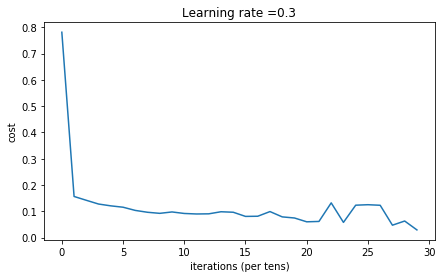

In [19]:
# 训练深层神经网络模型
parameters = L_layer_model(train_X, train_Y, layers_dims, print_cost=True)

In [20]:
# 打印训练集和测试集的准确率
print('训练集准确率: %d' % float(compute_accuracy(parameters, train_X, train_Y) * 100) + '%')
print('测试集准确率: %d' % float(compute_accuracy(parameters, test_X, test_Y) * 100) + '%')

训练集准确率: 100%
测试集准确率: 90%


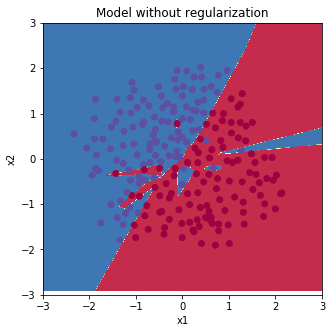

In [21]:
# 绘制决策边界图 可以看出明显存在过拟合
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-3, 3])
axes.set_ylim([-3, 3])
plot_decision_boundary(lambda x: predict(parameters, x.T), train_X, train_Y[0])

### 使用L2正则化的模型

In [22]:
# 计算带L2正则化的损失函数
def compute_cost_with_regularization(AL, Y, parameters, lambd):
    L = len(parameters) // 2
    
    cross_entropy_cost = compute_cost(AL, Y)
    L2_regularization_cost = np.sum(np.linalg.norm(parameters['W' + str(l)])**2 for l in range(1, L + 1)) * lambd / Y.shape[1] / 2.
    
    return cross_entropy_cost + L2_regularization_cost

In [23]:
# 计算带L2正则化的反向传播 Sigmoid->ReLU->...->ReLU
def backward_propagate_with_regularization(parameters, Y, caches, lambd):
    L = len(parameters) // 2
    
    grads = {}
    
    dZ = caches['A' + str(L)] - Y # cross-entropy cost对AL的偏导数 * sigmoid的导数
    grads['dW' + str(L)] = (dZ @ caches['A' + str(L - 1)].T + parameters['W' + str(L)] * lambd) / dZ.shape[1]
    grads['db' + str(L)] = np.mean(dZ, axis=1, keepdims=True)
    
    for l in reversed(range(1, L)):
        dZ =  parameters['W' + str(l + 1)].T @ dZ * (caches['A' + str(l)] > 0) # ReLU的导数
        grads['dW' + str(l)] = (dZ @ caches['A' + str(l - 1)].T + parameters['W' + str(l)] * lambd) / dZ.shape[1]
        grads['db' + str(l)] = np.mean(dZ, axis=1, keepdims=True)
    
    return grads

In [24]:
def L_layer_model_with_regularization(X, Y, layers_dims, learning_rate = 0.3, num_iterations = 30000, print_cost = False, lambd = 0):
    # 初始化参数 W1 b1 ... WL bL
    parameters = initialize_parameters_he(layers_dims)
    
    # 损失函数记录
    costs = []
    
    # 梯度下降法循环迭代
    for i in range(num_iterations):
        AL, caches = forward_propagate(parameters, X)
        if print_cost:
            if i % 1000 == 0:
                cost = compute_cost_with_regularization(AL, Y, parameters, lambd)
                costs.append(cost)
                if i % 10000 == 0:
                    print ("Cost after iteration %i: %f" %(i, cost))
        grads = backward_propagate_with_regularization(parameters, Y, caches, lambd)
        parameters = update_parameters(parameters, grads, learning_rate)
    
    # 绘制损失函数
    if print_cost:
        plt.figure(figsize=(7.0, 4.0))
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
    return parameters

Cost after iteration 0: 1.328244
Cost after iteration 10000: 0.227296
Cost after iteration 20000: 0.227273


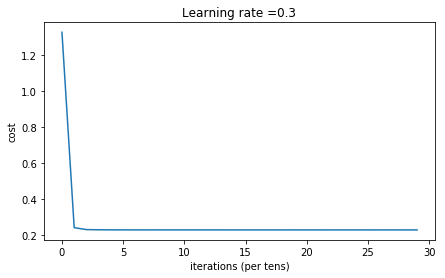

In [25]:
# 训练深层神经网络模型
parameters = L_layer_model_with_regularization(train_X, train_Y, layers_dims, print_cost=True, lambd = 0.7)

In [26]:
# 打印训练集和测试集的准确率
print('训练集准确率: %d' % float(compute_accuracy(parameters, train_X, train_Y) * 100) + '%')
print('测试集准确率: %d' % float(compute_accuracy(parameters, test_X, test_Y) * 100) + '%')

训练集准确率: 94%
测试集准确率: 94%


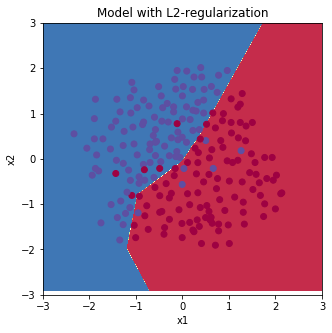

In [27]:
# 绘制带L2正则化的决策边界图
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-3, 3])
axes.set_ylim([-3, 3])
plot_decision_boundary(lambda x: predict(parameters, x.T), train_X, train_Y[0])

### 使用Dropout正则化的模型

In [28]:
# 计算带Dropout正则化的正向传播 ReLU->ReLU->...->Sigmoid
def forward_propagate_with_dropout(parameters, X, keep_prob = 0.5):
    L = len(parameters) // 2
    
    caches = {}
    
    A = X
    caches['A0'] = A
    for l in range(1, L):
        Z = parameters['W' + str(l)] @ A + parameters['b' + str(l)]
        D = np.random.rand(Z.shape[0], Z.shape[1]) < keep_prob # dropout mask
        A = relu(Z) * D / keep_prob
        caches['A' + str(l)] = A
        caches['D' + str(l)] = D
    
    Z = parameters['W' + str(L)] @ A + parameters['b' + str(L)]
    A = sigmoid(Z)
    caches['A' + str(L)] = A
    
    return A, caches

In [29]:
# 计算带Dropout正则化的反向传播 Sigmoid->ReLU->...->ReLU
def backward_propagate_with_dropout(parameters, Y, caches, keep_prob):
    L = len(parameters) // 2
    
    grads = {}
    
    dZ = caches['A' + str(L)] - Y # cross-entropy cost对AL的偏导数 * sigmoid的导数
    grads['dW' + str(L)] = dZ @ caches['A' + str(L - 1)].T / dZ.shape[1]
    grads['db' + str(L)] = np.mean(dZ, axis=1, keepdims=True)
    
    for l in reversed(range(1, L)):
        dZ =  parameters['W' + str(l + 1)].T @ dZ * caches['D' + str(l)] / keep_prob * (caches['A' + str(l)] > 0) # ReLU的导数
        grads['dW' + str(l)] = dZ @ caches['A' + str(l - 1)].T / dZ.shape[1]
        grads['db' + str(l)] = np.mean(dZ, axis=1, keepdims=True)
    
    return grads

In [30]:
def L_layer_model_with_dropout(X, Y, layers_dims, learning_rate = 0.3, num_iterations = 30000, print_cost = False, keep_prob = 1):
    # 初始化参数 W1 b1 ... WL bL
    parameters = initialize_parameters_he(layers_dims)
    
    # 损失函数记录
    costs = []
    
    # 梯度下降法循环迭代
    for i in range(num_iterations):
        AL, caches = forward_propagate_with_dropout(parameters, X, keep_prob)
        if print_cost:
            if i % 1000 == 0:
                cost = compute_cost(AL, Y)
                costs.append(cost)
                if i % 10000 == 0:
                    print ("Cost after iteration %i: %f" %(i, cost))
        grads = backward_propagate_with_dropout(parameters, Y, caches, keep_prob)
        parameters = update_parameters(parameters, grads, learning_rate)
    
    # 绘制损失函数
    if print_cost:
        plt.figure(figsize=(7.0, 4.0))
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
    return parameters

Cost after iteration 0: 1.040915
Cost after iteration 10000: 0.174424
Cost after iteration 20000: 0.138629


D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


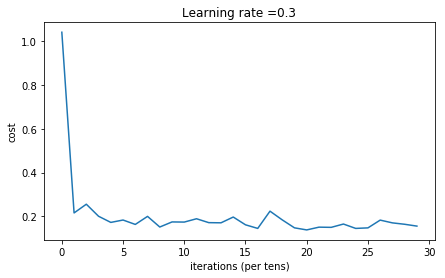

In [31]:
# 训练深层神经网络模型
parameters = L_layer_model_with_dropout(train_X, train_Y, layers_dims, print_cost=True, keep_prob = 0.86)

In [32]:
# 打印训练集和测试集的准确率
print('训练集准确率: %d' % float(compute_accuracy(parameters, train_X, train_Y) * 100) + '%')
print('测试集准确率: %d' % float(compute_accuracy(parameters, test_X, test_Y) * 100) + '%')

训练集准确率: 94%
测试集准确率: 92%


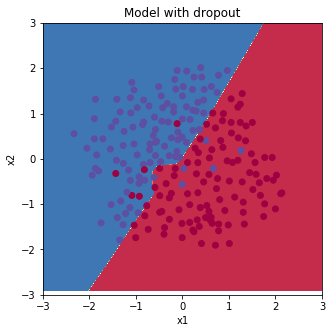

In [33]:
# 绘制带Dropout正则化的决策边界图
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-3, 3])
axes.set_ylim([-3, 3])
plot_decision_boundary(lambda x: predict(parameters, x.T), train_X, train_Y[0])